In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_lfw_people


In [10]:
faces = fetch_lfw_people(min_faces_per_person=60)


In [11]:
faces.target[:10]


array([1, 3, 3, 3, 5, 3, 6, 3, 7, 0])

In [12]:
faces.images.shape


(1348, 62, 47)

In [13]:
faces

{'data': array([[0.53333336, 0.52418303, 0.49673203, ..., 0.00653595, 0.00653595,
         0.00130719],
        [0.28627452, 0.20784314, 0.2535948 , ..., 0.96993464, 0.95032686,
         0.9346406 ],
        [0.31633988, 0.3895425 , 0.275817  , ..., 0.4261438 , 0.7895425 ,
         0.9555555 ],
        ...,
        [0.11633987, 0.11111111, 0.10196079, ..., 0.5660131 , 0.579085  ,
         0.5542484 ],
        [0.19346406, 0.21045752, 0.29150328, ..., 0.6875817 , 0.6575164 ,
         0.5908497 ],
        [0.12418301, 0.09673203, 0.10849673, ..., 0.12941177, 0.16209151,
         0.29150328]], dtype=float32),
 'images': array([[[0.53333336, 0.52418303, 0.49673203, ..., 0.2653595 ,
          0.2653595 , 0.26013073],
         [0.56993467, 0.545098  , 0.4797386 , ..., 0.2627451 ,
          0.2627451 , 0.26013073],
         [0.5882353 , 0.5398693 , 0.475817  , ..., 0.2640523 ,
          0.26013073, 0.25751635],
         ...,
         [0.59738564, 0.7176471 , 0.40261438, ..., 0.00653595,
     

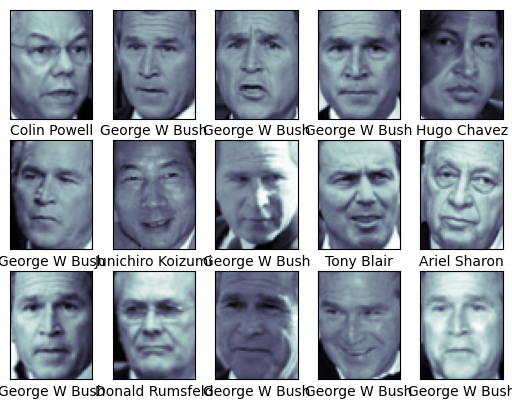

In [14]:
# Checking out sample images

fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

In [15]:
#Building model with PCA & SVC
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

In [16]:
pca = PCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')

model = make_pipeline(pca, svc)

In [17]:
# train, test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(faces['data'], faces['target'], test_size=0.2, random_state=42)


In [18]:
#Find Best Model using Grid Search CV
from sklearn.model_selection import GridSearchCV

param_grid ={
    'svc__C': [1, 5, 10, 15],
    'svc__gamma': [0.0001, 0.0005, 0.001, 0.005],
}


grid = GridSearchCV(model, param_grid=param_grid, cv=5)
%time grid.fit(X_train, y_train)



CPU times: user 41.7 s, sys: 476 ms, total: 42.2 s
Wall time: 25.6 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca',
                                        PCA(n_components=150, random_state=42,
                                            whiten=True)),
                                       ('svc', SVC(class_weight='balanced'))]),
             param_grid={'svc__C': [1, 5, 10, 15],
                         'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]})

In [19]:
grid.best_params_

{'svc__C': 1, 'svc__gamma': 0.005}

In [20]:
grid.best_estimator_

Pipeline(steps=[('pca', PCA(n_components=150, random_state=42, whiten=True)),
                ('svc', SVC(C=1, class_weight='balanced', gamma=0.005))])

In [21]:
#Prediction using best model
final_model = grid.best_estimator_
y_pred = final_model.predict(X_test)


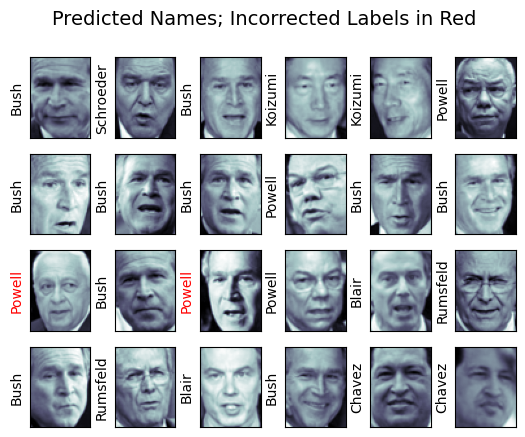

In [22]:
#Visualizing the data

fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(X_test[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[y_pred[i]].split()[-1], 
                  color='black' if y_pred[i] == y_test[i] # correct label
                  else 'red') # incorrect label

fig.suptitle('Predicted Names; Incorrected Labels in Red', size=14);

In [23]:
#Evaluation Metrics
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, 
                            target_names=faces.target_names))


                   precision    recall  f1-score   support

     Ariel Sharon       0.90      0.75      0.82        12
     Colin Powell       0.72      0.94      0.81        51
  Donald Rumsfeld       0.88      0.88      0.88        25
    George W Bush       0.97      0.88      0.92        98
Gerhard Schroeder       0.88      0.71      0.79        21
      Hugo Chavez       0.85      0.73      0.79        15
Junichiro Koizumi       1.00      1.00      1.00        10
       Tony Blair       0.90      0.92      0.91        38

         accuracy                           0.87       270
        macro avg       0.89      0.85      0.86       270
     weighted avg       0.89      0.87      0.88       270



In [24]:

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm = cm.T

print(cm)


[[ 9  0  0  0  0  1  0  0]
 [ 1 48  3 10  0  2  0  3]
 [ 2  1 22  0  0  0  0  0]
 [ 0  1  0 86  2  0  0  0]
 [ 0  1  0  1 15  0  0  0]
 [ 0  0  0  1  1 11  0  0]
 [ 0  0  0  0  0  0 10  0]
 [ 0  0  0  0  3  1  0 35]]


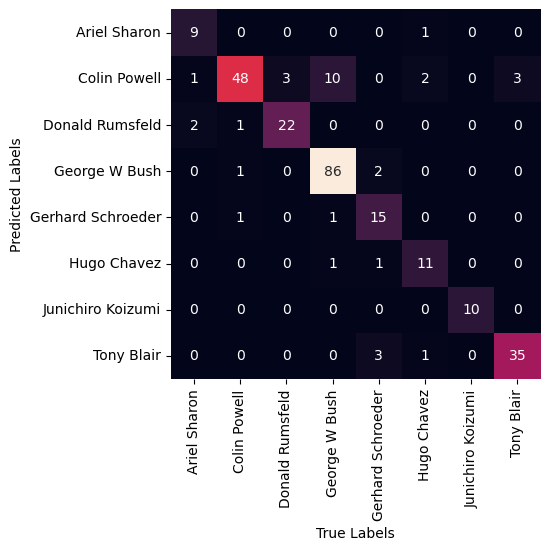

In [25]:


sns.heatmap(data=cm, 
            square=True, 
            annot=True, 
            cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names
           );

plt.xlabel('True Labels')
plt.ylabel('Predicted Labels');



In [26]:
import pickle

# Save the trained model to a .pkl file using pickle
with open('face-recognition-model.pkl', 'wb') as model_file:
    pickle.dump(final_model, model_file)